In [12]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Tensorflow_helper import choose_gpu_by_id
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)
# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# ------------------------------------------ import helpers
# this should import glob, os, and many other standard libs
from src.utils.Notebook_imports import *
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
# local imports
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D, show_phases, show_phases_transpose
from src.utils.KerasCallbacks import get_callbacks
from src.data.Dataset import get_trainings_files

# import external libs
import cv2
import pandas as pd


EXPERIMENT = 'cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8'
#EXPERIMENT = 'baseline_label_transpose_smooth05/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_NOaug_b8'
# EXPERIMENT = 'mased_scores/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_shift_rotate_reflectbordersgridaug'
timestemp = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")) # ad a timestep to each project to make repeated experiments unique

EXPERIMENTS_ROOT = 'exp/'
EXP_PATH = os.path.join(EXPERIMENTS_ROOT, EXPERIMENT, timestemp)
MODEL_PATH = os.path.join(EXP_PATH, 'model', )
TENSORBOARD_PATH = os.path.join(EXP_PATH, 'tensorboard_logs')
CONFIG_PATH = os.path.join(EXP_PATH,'config')
HISTORY_PATH = os.path.join(EXP_PATH, 'history')
ensure_dir(MODEL_PATH)
ensure_dir(TENSORBOARD_PATH)
ensure_dir(CONFIG_PATH)
ensure_dir(HISTORY_PATH)

# define the input data paths and fold 
# first to the 4D Nrrd files, 
# second to a dataframe with a mapping of the Fold-number
# Finally the path to the metadata
DATA_PATH_SAX = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/'
DF_FOLDS = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/df_kfold.csv'
DF_META = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase'
FOLD = 0

# General params
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 8 # 32, 64, 24, 16, 1 for 3D use: 4
GENERATOR_WORKER = BATCHSIZE # if not set, use batchsize
EPOCHS = 100

DIM = [8, 64, 64] # network input shape for spacing of 3, (z,y,x)
T_SHAPE = 36
SPACING = [8, 3, 3] # if resample, resample to this spacing, (z,y,x)

# Model params
DEPTH = 4 # depth of the encoder
FILTERS = 32 # initial number of filters, will be doubled after each downsampling block
M_POOL = [1, 2, 2]# size of max-pooling used for downsampling and upsampling
F_SIZE = [3, 3, 3] # conv filter size
BN_FIRST = False # decide if batch normalisation between conv and activation or afterwards
BATCH_NORMALISATION = True # apply BN or not
PAD = 'same' # padding strategy of the conv layers
KERNEL_INIT = 'he_normal' # conv weight initialisation
OPTIMIZER = 'adam' # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'relu' # tf.keras.layers.LeakyReLU(), relu or any other non linear activation function
LEARNING_RATE = 1e-4 # start with a huge lr to converge fast
REDUCE_LR_ON_PLAEAU_PATIENCE = 5
DECAY_FACTOR = 0.7 # Define a learning rate decay for the ReduceLROnPlateau callback
POLY_LR_DECAY = False
MIN_LR = 1e-12 # minimal lr, smaller lr does not improve the model
DROPOUT_MIN = 0.4 # lower dropout at the shallow layers
DROPOUT_MAX = 0.5 # higher dropout at the deep layers

# Callback params
MONITOR_FUNCTION = 'loss'
MONITOR_MODE = 'min'
SAVE_MODEL_FUNCTION = 'loss'
SAVE_MODEL_MODE = 'min'
MODEL_PATIENCE = 20
SAVE_LEARNING_PROGRESS_AS_TF = True

# Generator and Augmentation params
BORDER_MODE = cv2.BORDER_REFLECT_101 # border mode for the data generation
IMG_INTERPOLATION = cv2.INTER_LINEAR # image interpolation in the genarator
MSK_INTERPOLATION = cv2.INTER_NEAREST # mask interpolation in the generator
AUGMENT = True # a compose of 2D augmentation (grid distortion, 90degree rotation, brightness and shift)
AUGMENT_PROB = 0.8
AUGMENT_PHASES = True
AUGMENT_PHASES_RANGE = (-3,3)
REPEAT_ONEHOT = True
SHUFFLE = True
RESAMPLE = True
HIST_MATCHING = False
SCALER = 'MinMax' # MinMax, Standard or Robust
# We define 5 target phases and a background phase for the pad/empty volumes 
PHASES = len(['ED#', 'MS#', 'ES#', 'PF#', 'MD#']) # skipped 'pad backround manually added', due to repeating
TARGET_SMOOTHING = True
SMOOTHING_KERNEL_SIZE = 12
SMOOTHING_LOWER_BORDER = 1
SMOOTHING_UPPER_BORDER = 5
SMOOTHING_WEIGHT_CORRECT = 10
Console_and_file_logger(EXPERIMENT, logging.INFO)
config = init_config(config=locals(), save=True)
print(config)
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))

2021-03-16 15:09:00,379 INFO -------------------- Start --------------------
2021-03-16 15:09:00,379 INFO Working directory: /mnt/ssd/git/dynamic-cmr-models.
2021-03-16 15:09:00,380 INFO Log file: ./logs/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8.log
2021-03-16 15:09:00,380 INFO Log level for console: INFO
2021-03-16 15:09:00,385 INFO Is built with tensorflow: True
2021-03-16 15:09:00,385 INFO Visible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2021-03-16 15:09:00,391 INFO Local devices: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
in

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models
['/gpu:0', '/gpu:1']
{'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'SEED': 42, 'EXPERIMENT': 'cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8', 'EXPERIMENTS_ROOT': 'exp/', 'EXP_PATH': 'exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09', 'MODEL_PATH': 'exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model', 'TENSORBOARD_PATH': 'exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/tensorboard_logs', 'CONFIG_PATH': 'exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/config', 'HISTORY_PATH': 'exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/history', 'DATA_PATH_SAX': '/mnt/ssd/data/gcn/02_imported_

In [13]:
# Load SAX volumes
x_train_sax, y_train_sax, x_val_sax, y_val_sax =  get_trainings_files(data_path=DATA_PATH_SAX,path_to_folds_df=DF_FOLDS, fold=FOLD)
logging.info('SAX train CMR: {}, SAX train masks: {}'.format(len(x_train_sax), len(y_train_sax)))
logging.info('SAX val CMR: {}, SAX val masks: {}'.format(len(x_val_sax), len(y_val_sax)))

2021-03-16 15:09:01,729 INFO no files found, try to load with clean.nrrd/mask.nrrd pattern
2021-03-16 15:09:01,735 INFO Found 278 images/masks in /mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAX/
2021-03-16 15:09:01,735 INFO Patients train: 209
2021-03-16 15:09:01,749 INFO Selected 209 of 278 files with 209 of 279 patients for training fold 0
2021-03-16 15:09:01,750 INFO SAX train CMR: 209, SAX train masks: 209
2021-03-16 15:09:01,751 INFO SAX val CMR: 69, SAX val masks: 69


In [14]:
# check if we find each patient in the corresponding dataframe
import re
import pandas as pd
METADATA_FILE = config.get('DF_META', '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase')
df = pd.read_csv(METADATA_FILE)
DF_METADATA = df[['patient', 'ED#', 'MS#', 'ES#', 'PF#', 'MD#']]

In [15]:
files_ = x_train_sax + x_val_sax
info('Check if we find the patient ID and phase mapping for all: {} files.'.format(len(files_)))
for x in files_:
    try:
        patient_str = re.search('-(.{8})_', x).group(1).upper()
        
        assert(len(patient_str) == 8), 'matched patient ID from the phase sheet has a length of: {}'.format(len(patient_str))
        # returns the indices in the following order: 'ED#', 'MS#', 'ES#', 'PF#', 'MD#'
        # reduce by one, as the indexes start at 0, the excel-sheet at 1
        ind = DF_METADATA[DF_METADATA.patient.str.contains(patient_str)][['ED#', 'MS#', 'ES#', 'PF#', 'MD#']]
        indices = ind.values[0].astype(int) -1
        
    except Exception as e:
        logging.info(patient_str)
        logging.info(ind)
        logging.info('indices: \n{}'.format(indices))
info('Done!')

2021-03-16 15:09:02,701 INFO Check if we find the patient ID and phase mapping for all: 278 files.
2021-03-16 15:09:02,962 INFO Done!


In [16]:
@interact
def search_p_in_df(search_str = ''):
    return DF_METADATA[DF_METADATA['patient'].str.contains(search_str)]

interactive(children=(Text(value='', description='search_str'), Output()), _dom_classes=('widget-interact',))

In [17]:
# initialise a generator with these files
# logging.getLogger().setLevel(logging.INFO)
from src.data.Generators import PhaseRegressionGenerator
#config['SHUFFLE'] = False
#config['AUGMENT'] = False
#config['RESAMPLE'] = True
#config['AUGMENT_PHASES'] = False
batch_generator = PhaseRegressionGenerator(x_train_sax, x_train_sax, config=config)
val_config = config.copy()
val_config['AUGMENT'] = False
val_config['AUGMENT_PHASES'] = False
validation_generator = PhaseRegressionGenerator(x_val_sax, x_val_sax , config=val_config)

2021-03-16 15:09:03,219 INFO Create DataGenerator
2021-03-16 15:09:03,220 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [8, 3, 3]
 batchsize: 8
 Scaler: MinMax
 Images: 209 
 Augment: True 
 Thread workers: 8
2021-03-16 15:09:03,221 INFO Data will be augmented (shift,scale and rotate) with albumentation
2021-03-16 15:09:03,234 INFO Smoothing kernel: 
[ 1.   1.8  2.6  3.4  4.2  5.  10.   5.   4.2  3.4  2.6  1.8  1. ]
2021-03-16 15:09:03,235 INFO Temporal phase augmentation: 
True
Repeat volume: 
True
2021-03-16 15:09:03,533 INFO Create DataGenerator
2021-03-16 15:09:03,533 INFO Datagenerator created with: 
 shape: [8, 64, 64]
 spacing: [8, 3, 3]
 batchsize: 8
 Scaler: MinMax
 Images: 69 
 Augment: False 
 Thread workers: 8
2021-03-16 15:09:03,534 INFO No augmentation
2021-03-16 15:09:03,547 INFO Smoothing kernel: 
[ 1.   1.8  2.6  3.4  4.2  5.  10.   5.   4.2  3.4  2.6  1.8  1. ]
2021-03-16 15:09:03,547 INFO Temporal phase augmentation: 
False
Repeat volume: 
True


In [18]:
# visualise one batch
generator = batch_generator
@interact_manual
def select_image_in_batch(batch = (0,len(generator), 1), 
                          im = (0,BATCHSIZE- 1, 1), 
                          slice_n=(1,11), 
                          save=False, 
                          filepath='data/temp/', 
                          filename='temp_x.npy',
                         show_overview=True,
                         show_input_vol=False):
    
    import time
    global inputs, outputs, gt_len_msk
    phases = ['ED', 'MS', 'ES', 'PF', 'MD']
    t1 = time.time()
    inputs, outputs = generator.__getitem__(batch)
    onehot, gt_len_msk = np.split(outputs, indices_or_sections=2,axis=1)
    logging.info('Preprocessing took: {:0.3f}'.format(time.time() - t1))
    print(inputs.shape, outputs.shape)
    print('selected batch : ' + str(batch))
    if show_overview:

        show_phases(outputs)
        plt.show()
        
        selected_input = inputs[im]
        selected_output = onehot[im][0]
        selected_gt_len_msk = gt_len_msk[im][0]
        selected_gtlen = int(np.sum((selected_gt_len_msk[0]),axis=0))
        logging.info('GT length: {}'.format(selected_gtlen))
        logging.debug('pad: \n{}'.format(selected_output))
        
        """f, axs = plt.subplots(1,2,figsize=(12,4))
        i = 0
        temp_y = selected_output
        print(np.sum(temp_y, axis=1))

        # ind_gt = np.argmax(temp_y[:selected_gtlen,:], axis=0) # before we had the gt mask
        ind_gt = np.argmax(temp_y * selected_gt_len_msk, axis=1)
        axs[0].title.set_text('y')
        axs[0].set_xticks(ind_gt, minor=False)
        axs[0].set_yticks([0,1,2,3,4], minor=False)
        axs[0].set_yticklabels(phases, rotation =45)
        axs[0].imshow(temp_y, aspect='auto', )
        axs[1].hist(selected_input.flatten(), bins=np.linspace(0.1,1,20))
        f.tight_layout()
        plt.show()"""
    
    if show_input_vol:
        f, axs = plt.subplots(1,1,figsize=(4,4))
        axs.hist(selected_input.flatten(), bins=np.linspace(0.1,1,20))
        f.tight_layout()
        plt.show()
        
        list(map(lambda x: show_2D_or_3D(img=x, interpol='bilinear',dpi=100,f_size=(5,5)), selected_input[::slice_n]))
        
        
    if save:
        ensure_dir(filepath)
        np.save(os.path.join(filepath, filename), x[im])
        logging.info('saved to {}'.format(os.path.join(filepath, filename)))


interactive(children=(IntSlider(value=13, description='batch', max=26), IntSlider(value=3, description='im', m…

In [19]:
# test if all batches are processable
"""for b in range(len(batch_generator)):
    print(b)
    for im in range(BATCHSIZE):
        select_image_in_batch(batch=b,im=im, slice_n=5, show_overview=True, show_input_vol=True)"""

'for b in range(len(batch_generator)):\n    print(b)\n    for im in range(BATCHSIZE):\n        select_image_in_batch(batch=b,im=im, slice_n=5, show_overview=True, show_input_vol=True)'

In [20]:
from src.models.Models import create_PhaseRegressionModel
model = create_PhaseRegressionModel(config)

Shape after the temporal encoder
(None, 36, 8, 4, 4, 512)
Shape after GAP
(None, 36, 512)
Shape after Bi-LSTM layer
(None, 36, 512)
Shape after final conv layer
(None, 36, 5)


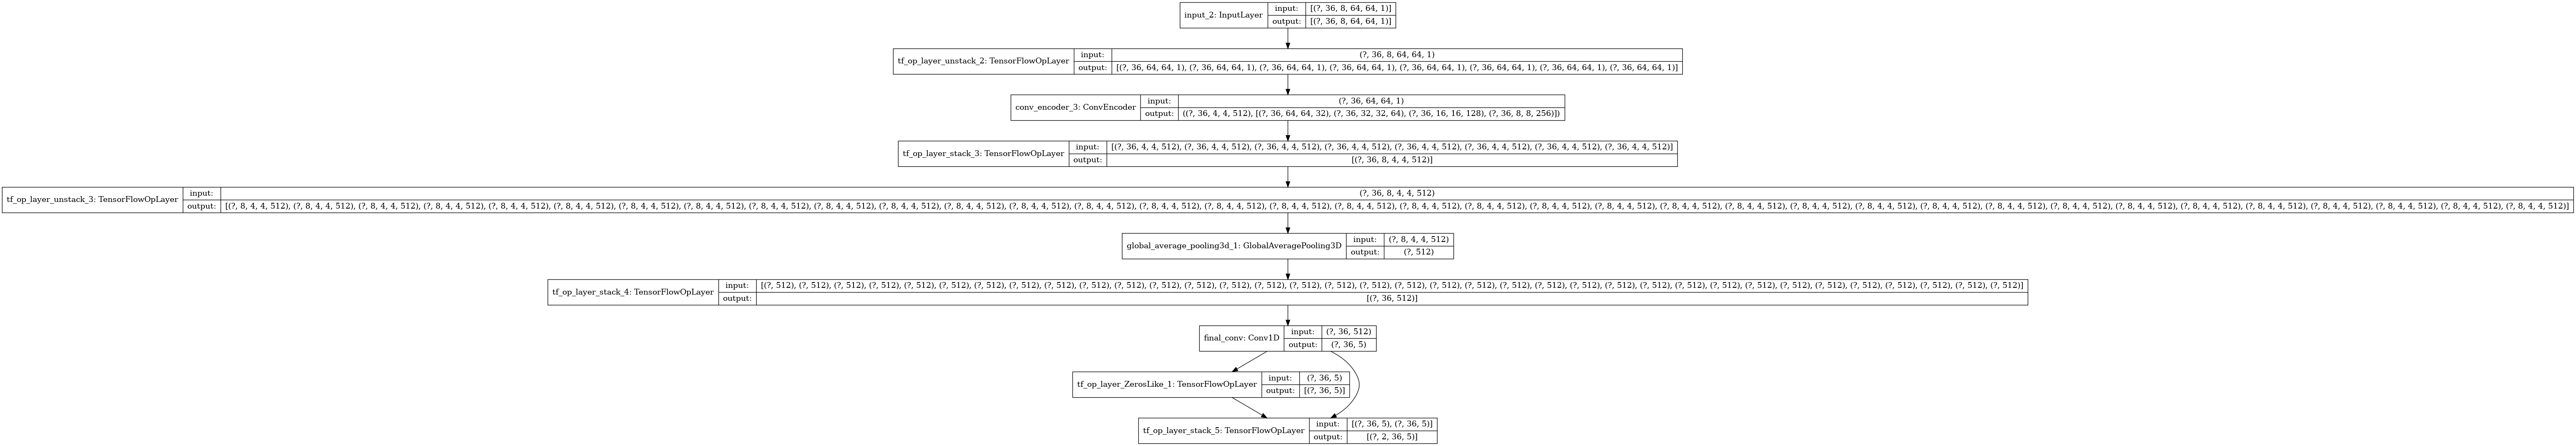

In [21]:
# write the model summary to a txt file
# Open the file
with open(os.path.join(EXP_PATH, 'model_summary.txt') ,'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
    
tf.keras.utils.plot_model(
    model, show_shapes=True,
    to_file=os.path.join(EXP_PATH, 'model.png'),
    show_layer_names=True, 
    rankdir='TB', 
    expand_nested=True, dpi=96
)
    
#model.summary(line_length=150)

In [22]:
initial_epoch = 0

results = model.fit(
    x=batch_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks = get_callbacks(config, batch_generator,validation_generator),
    initial_epoch=initial_epoch,
    max_queue_size=12,
    use_multiprocessing=False,
    verbose=1)

2021-03-16 15:09:09,489 INFO feed 4 Tensorboard is ready


Epoch 1/100
26/26 [==============================] - ETA: 0s - loss: 1.1796 - mse_wrapper: 1.1796 - ca_wrapper: 0.4030 - meandiff: 13.7356

2021-03-16 15:10:12,834 INFO (4, 2, 36, 5)
2021-03-16 15:10:13,378 INFO (4, 2, 36, 5)



Epoch 00001: loss improved from inf to 1.17962, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 36s 1s/step - loss: 1.1796 - mse_wrapper: 1.1796 - ca_wrapper: 0.4030 - meandiff: 13.7356 - val_loss: 5.6683 - val_mse_wrapper: 5.6683 - val_ca_wrapper: 0.2938 - val_meandiff: 20.8438 - lr: 1.0000e-04
Epoch 2/100
26/26 [==============================] - ETA: 0s - loss: 0.9249 - mse_wrapper: 0.9249 - ca_wrapper: 0.5514 - meandiff: 10.4808

2021-03-16 15:10:47,119 INFO (4, 2, 36, 5)
2021-03-16 15:10:47,660 INFO (4, 2, 36, 5)



Epoch 00002: loss improved from 1.17962 to 0.92488, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 32s 1s/step - loss: 0.9249 - mse_wrapper: 0.9249 - ca_wrapper: 0.5514 - meandiff: 10.4808 - val_loss: 1.5367 - val_mse_wrapper: 1.5367 - val_ca_wrapper: 0.4514 - val_meandiff: 10.8438 - lr: 1.0000e-04
Epoch 3/100
26/26 [==============================] - ETA: 0s - loss: 0.7705 - mse_wrapper: 0.7705 - ca_wrapper: 0.6752 - meandiff: 8.7019

2021-03-16 15:11:23,134 INFO (4, 2, 36, 5)
2021-03-16 15:11:23,655 INFO (4, 2, 36, 5)



Epoch 00003: loss improved from 0.92488 to 0.77051, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.7705 - mse_wrapper: 0.7705 - ca_wrapper: 0.6752 - meandiff: 8.7019 - val_loss: 0.9283 - val_mse_wrapper: 0.9283 - val_ca_wrapper: 0.7083 - val_meandiff: 6.2031 - lr: 1.0000e-04
Epoch 4/100
26/26 [==============================] - ETA: 0s - loss: 0.7156 - mse_wrapper: 0.7156 - ca_wrapper: 0.7089 - meandiff: 7.1250

2021-03-16 15:11:59,513 INFO (4, 2, 36, 5)
2021-03-16 15:12:00,352 INFO (4, 2, 36, 5)



Epoch 00004: loss improved from 0.77051 to 0.71560, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 35s 1s/step - loss: 0.7156 - mse_wrapper: 0.7156 - ca_wrapper: 0.7089 - meandiff: 7.1250 - val_loss: 1.0164 - val_mse_wrapper: 1.0164 - val_ca_wrapper: 0.7352 - val_meandiff: 5.6875 - lr: 1.0000e-04
Epoch 5/100
26/26 [==============================] - ETA: 0s - loss: 0.6417 - mse_wrapper: 0.6417 - ca_wrapper: 0.7369 - meandiff: 6.2260
Epoch 00005: loss improved from 0.71560 to 0.64174, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.6417 - mse_wrapper: 0.6417 - ca_wrapper: 0.7369 - meandiff: 6.2260 - val_loss: 0.8727 - val_mse_wrapper: 0.8727 - val_ca_wrapper: 0.7391 - val_meandiff: 5.0938 - lr: 1.0000e-04
Epoch 6/100

2021-03-16 15:13:11,990 INFO (4, 2, 36, 5)
2021-03-16 15:13:12,535 INFO (4, 2, 36, 5)



Epoch 00006: loss improved from 0.64174 to 0.63285, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 35s 1s/step - loss: 0.6329 - mse_wrapper: 0.6329 - ca_wrapper: 0.7441 - meandiff: 6.0721 - val_loss: 1.8115 - val_mse_wrapper: 1.8115 - val_ca_wrapper: 0.6523 - val_meandiff: 6.0156 - lr: 1.0000e-04
Epoch 7/100
26/26 [==============================] - ETA: 0s - loss: 0.5982 - mse_wrapper: 0.5982 - ca_wrapper: 0.7644 - meandiff: 5.5240
Epoch 00007: loss improved from 0.63285 to 0.59823, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.5982 - mse_wrapper: 0.5982 - ca_wrapper: 0.7644 - meandiff: 5.5240 - val_loss: 0.7607 - val_mse_wrapper: 0.7607 - val_ca_wrapper: 0.7930 - val_meandiff: 5.2500 - lr: 1.0000e-04
Epoch 8/100

2021-03-16 15:14:25,706 INFO (4, 2, 36, 5)
2021-03-16 15:14:26,248 INFO (4, 2, 36, 5)



Epoch 00008: loss improved from 0.59823 to 0.55602, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 35s 1s/step - loss: 0.5560 - mse_wrapper: 0.5560 - ca_wrapper: 0.7814 - meandiff: 5.1058 - val_loss: 1.3230 - val_mse_wrapper: 1.3230 - val_ca_wrapper: 0.6719 - val_meandiff: 4.9844 - lr: 1.0000e-04
Epoch 9/100
26/26 [==============================] - ETA: 0s - loss: 0.5537 - mse_wrapper: 0.5537 - ca_wrapper: 0.7792 - meandiff: 4.7019
Epoch 00009: loss improved from 0.55602 to 0.55370, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.5537 - mse_wrapper: 0.5537 - ca_wrapper: 0.7792 - meandiff: 4.7019 - val_loss: 0.7332 - val_mse_wrapper: 0.7332 - val_ca_wrapper: 0.7561 - val_meandiff: 5.5781 - lr: 1.0000e-04
Epoch 10/10

2021-03-16 15:15:37,403 INFO (4, 2, 36, 5)
2021-03-16 15:15:37,926 INFO (4, 2, 36, 5)



Epoch 00010: loss improved from 0.55370 to 0.53926, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 35s 1s/step - loss: 0.5393 - mse_wrapper: 0.5393 - ca_wrapper: 0.7899 - meandiff: 4.7404 - val_loss: 0.7456 - val_mse_wrapper: 0.7456 - val_ca_wrapper: 0.7509 - val_meandiff: 4.0312 - lr: 1.0000e-04
Epoch 11/100
26/26 [==============================] - ETA: 0s - loss: 0.5344 - mse_wrapper: 0.5344 - ca_wrapper: 0.7869 - meandiff: 4.4279
Epoch 00011: loss improved from 0.53926 to 0.53437, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.5344 - mse_wrapper: 0.5344 - ca_wrapper: 0.7869 - meandiff: 4.4279 - val_loss: 1.4991 - val_mse_wrapper: 1.4991 - val_ca_wrapper: 0.5174 - val_meandiff: 4.7656 - lr: 1.0000e-04
Epoch 12/1

2021-03-16 15:16:49,432 INFO (4, 2, 36, 5)
2021-03-16 15:16:49,976 INFO (4, 2, 36, 5)



Epoch 00012: loss improved from 0.53437 to 0.51259, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 35s 1s/step - loss: 0.5126 - mse_wrapper: 0.5126 - ca_wrapper: 0.7970 - meandiff: 4.3269 - val_loss: 0.8415 - val_mse_wrapper: 0.8415 - val_ca_wrapper: 0.7188 - val_meandiff: 4.5312 - lr: 1.0000e-04
Epoch 13/100
26/26 [==============================] - ETA: 0s - loss: 0.5160 - mse_wrapper: 0.5160 - ca_wrapper: 0.7969 - meandiff: 4.3558
Epoch 00013: loss did not improve from 0.51259
26/26 [==============================] - 34s 1s/step - loss: 0.5160 - mse_wrapper: 0.5160 - ca_wrapper: 0.7969 - meandiff: 4.3558 - val_loss: 0.7290 - val_mse_wrapper: 0.7290 - val_ca_wrapper: 0.7526 - val_meandiff: 4.1094 - lr: 1.0000e-04
Epoch 14/100
26/26 [==============================] - ETA: 0s - loss: 0.4929 - mse_wrapper: 0.4929 - ca_wrapper: 0.8064 - meandiff: 4.4135

2021-03-16 15:18:01,597 INFO (4, 2, 36, 5)
2021-03-16 15:18:02,151 INFO (4, 2, 36, 5)



Epoch 00014: loss improved from 0.51259 to 0.49287, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.4929 - mse_wrapper: 0.4929 - ca_wrapper: 0.8064 - meandiff: 4.4135 - val_loss: 0.8912 - val_mse_wrapper: 0.8912 - val_ca_wrapper: 0.7279 - val_meandiff: 5.0312 - lr: 1.0000e-04
Epoch 15/100
26/26 [==============================] - ETA: 0s - loss: 0.5056 - mse_wrapper: 0.5056 - ca_wrapper: 0.7965 - meandiff: 4.2837
Epoch 00015: loss did not improve from 0.49287
26/26 [==============================] - 33s 1s/step - loss: 0.5056 - mse_wrapper: 0.5056 - ca_wrapper: 0.7965 - meandiff: 4.2837 - val_loss: 0.5910 - val_mse_wrapper: 0.5910 - val_ca_wrapper: 0.7899 - val_meandiff: 4.6562 - lr: 1.0000e-04
Epoch 16/100
26/26 [==============================] - ETA: 0s - loss: 0.4876 - mse_wrapper: 0.4876 - ca_wrapper: 0.8038 - meandiff: 4.1923

2021-03-16 15:19:12,794 INFO (4, 2, 36, 5)
2021-03-16 15:19:13,386 INFO (4, 2, 36, 5)



Epoch 00016: loss improved from 0.49287 to 0.48756, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.4876 - mse_wrapper: 0.4876 - ca_wrapper: 0.8038 - meandiff: 4.1923 - val_loss: 1.0000 - val_mse_wrapper: 1.0000 - val_ca_wrapper: 0.7574 - val_meandiff: 4.6406 - lr: 1.0000e-04
Epoch 17/100
26/26 [==============================] - ETA: 0s - loss: 0.4838 - mse_wrapper: 0.4838 - ca_wrapper: 0.8042 - meandiff: 4.4279
Epoch 00017: loss improved from 0.48756 to 0.48380, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.4838 - mse_wrapper: 0.4838 - ca_wrapper: 0.8042 - meandiff: 4.4279 - val_loss: 0.9168 - val_mse_wrapper: 0.9168 - val_ca_wrapper: 0.7795 - val_meandiff: 4.2812 - lr: 1.0000e-04
Epoch 18/1

2021-03-16 15:20:23,188 INFO (4, 2, 36, 5)
2021-03-16 15:20:23,764 INFO (4, 2, 36, 5)



Epoch 00018: loss improved from 0.48380 to 0.46976, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.4698 - mse_wrapper: 0.4698 - ca_wrapper: 0.8134 - meandiff: 3.9856 - val_loss: 1.0051 - val_mse_wrapper: 1.0051 - val_ca_wrapper: 0.6719 - val_meandiff: 4.9219 - lr: 1.0000e-04
Epoch 19/100
26/26 [==============================] - ETA: 0s - loss: 0.4739 - mse_wrapper: 0.4739 - ca_wrapper: 0.8108 - meandiff: 4.1010
Epoch 00019: loss did not improve from 0.46976
26/26 [==============================] - 33s 1s/step - loss: 0.4739 - mse_wrapper: 0.4739 - ca_wrapper: 0.8108 - meandiff: 4.1010 - val_loss: 0.9059 - val_mse_wrapper: 0.9059 - val_ca_wrapper: 0.7348 - val_meandiff: 4.4062 - lr: 1.0000e-04
Epoch 20/100
26/26 [==============================] - ETA: 0s - loss: 0.4605 - mse_wrapper: 0.4605 - ca_wrapper: 0.8177 - meandiff: 4.0481

2021-03-16 15:21:34,296 INFO (4, 2, 36, 5)
2021-03-16 15:21:34,860 INFO (4, 2, 36, 5)



Epoch 00020: loss improved from 0.46976 to 0.46055, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.4605 - mse_wrapper: 0.4605 - ca_wrapper: 0.8177 - meandiff: 4.0481 - val_loss: 0.6684 - val_mse_wrapper: 0.6684 - val_ca_wrapper: 0.7765 - val_meandiff: 4.1406 - lr: 1.0000e-04
Epoch 21/100
26/26 [==============================] - ETA: 0s - loss: 0.4560 - mse_wrapper: 0.4560 - ca_wrapper: 0.8209 - meandiff: 3.9663
Epoch 00021: loss improved from 0.46055 to 0.45605, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.4560 - mse_wrapper: 0.4560 - ca_wrapper: 0.8209 - meandiff: 3.9663 - val_loss: 0.9242 - val_mse_wrapper: 0.9242 - val_ca_wrapper: 0.7387 - val_meandiff: 4.7656 - lr: 1.0000e-04
Epoch 22/1

2021-03-16 15:22:45,031 INFO (4, 2, 36, 5)
2021-03-16 15:22:45,567 INFO (4, 2, 36, 5)



Epoch 00022: loss did not improve from 0.45605
26/26 [==============================] - 34s 1s/step - loss: 0.4592 - mse_wrapper: 0.4592 - ca_wrapper: 0.8094 - meandiff: 3.9615 - val_loss: 0.9859 - val_mse_wrapper: 0.9859 - val_ca_wrapper: 0.7122 - val_meandiff: 4.2969 - lr: 1.0000e-04
Epoch 23/100
26/26 [==============================] - ETA: 0s - loss: 0.4410 - mse_wrapper: 0.4410 - ca_wrapper: 0.8188 - meandiff: 3.7067
Epoch 00023: loss improved from 0.45605 to 0.44097, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.4410 - mse_wrapper: 0.4410 - ca_wrapper: 0.8188 - meandiff: 3.7067 - val_loss: 0.7940 - val_mse_wrapper: 0.7940 - val_ca_wrapper: 0.7643 - val_meandiff: 4.2656 - lr: 1.0000e-04
Epoch 24/100
26/26 [==============================] - ETA: 0s - loss: 0.4434 - mse_wrapper: 0.4434 - ca_wrapper: 0.8233 - meandiff: 3.8750

2021-03-16 15:23:55,623 INFO (4, 2, 36, 5)
2021-03-16 15:23:56,141 INFO (4, 2, 36, 5)



Epoch 00024: loss did not improve from 0.44097
26/26 [==============================] - 34s 1s/step - loss: 0.4434 - mse_wrapper: 0.4434 - ca_wrapper: 0.8233 - meandiff: 3.8750 - val_loss: 0.9180 - val_mse_wrapper: 0.9180 - val_ca_wrapper: 0.7552 - val_meandiff: 4.2812 - lr: 1.0000e-04
Epoch 25/100
26/26 [==============================] - ETA: 0s - loss: 0.4333 - mse_wrapper: 0.4333 - ca_wrapper: 0.8267 - meandiff: 3.7452
Epoch 00025: loss improved from 0.44097 to 0.43331, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.4333 - mse_wrapper: 0.4333 - ca_wrapper: 0.8267 - meandiff: 3.7452 - val_loss: 0.7156 - val_mse_wrapper: 0.7156 - val_ca_wrapper: 0.7882 - val_meandiff: 4.7344 - lr: 1.0000e-04
Epoch 26/100
26/26 [==============================] - ETA: 0s - loss: 0.4435 - mse_wrapper: 0.4435 - ca_wrapper: 0.8236 - meandiff: 3.8365

2021-03-16 15:25:06,566 INFO (4, 2, 36, 5)
2021-03-16 15:25:07,127 INFO (4, 2, 36, 5)



Epoch 00026: loss did not improve from 0.43331
26/26 [==============================] - 34s 1s/step - loss: 0.4435 - mse_wrapper: 0.4435 - ca_wrapper: 0.8236 - meandiff: 3.8365 - val_loss: 0.6901 - val_mse_wrapper: 0.6901 - val_ca_wrapper: 0.7999 - val_meandiff: 4.2500 - lr: 1.0000e-04
Epoch 27/100
26/26 [==============================] - ETA: 0s - loss: 0.4338 - mse_wrapper: 0.4338 - ca_wrapper: 0.8220 - meandiff: 3.6875
Epoch 00027: loss did not improve from 0.43331
26/26 [==============================] - 33s 1s/step - loss: 0.4338 - mse_wrapper: 0.4338 - ca_wrapper: 0.8220 - meandiff: 3.6875 - val_loss: 0.7103 - val_mse_wrapper: 0.7103 - val_ca_wrapper: 0.7956 - val_meandiff: 4.3594 - lr: 1.0000e-04
Epoch 28/100
26/26 [==============================] - ETA: 0s - loss: 0.4255 - mse_wrapper: 0.4255 - ca_wrapper: 0.8311 - meandiff: 3.9423

2021-03-16 15:26:16,865 INFO (4, 2, 36, 5)
2021-03-16 15:26:17,419 INFO (4, 2, 36, 5)



Epoch 00028: loss improved from 0.43331 to 0.42553, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.4255 - mse_wrapper: 0.4255 - ca_wrapper: 0.8311 - meandiff: 3.9423 - val_loss: 0.6791 - val_mse_wrapper: 0.6791 - val_ca_wrapper: 0.7448 - val_meandiff: 4.3438 - lr: 1.0000e-04
Epoch 29/100
26/26 [==============================] - ETA: 0s - loss: 0.4424 - mse_wrapper: 0.4424 - ca_wrapper: 0.8204 - meandiff: 3.5962
Epoch 00029: loss did not improve from 0.42553
26/26 [==============================] - 33s 1s/step - loss: 0.4424 - mse_wrapper: 0.4424 - ca_wrapper: 0.8204 - meandiff: 3.5962 - val_loss: 1.2679 - val_mse_wrapper: 1.2679 - val_ca_wrapper: 0.6819 - val_meandiff: 5.0469 - lr: 1.0000e-04
Epoch 30/100
26/26 [==============================] - ETA: 0s - loss: 0.4419 - mse_wrapper: 0.4419 - ca_wrapper: 0.8181 - meandiff: 3.7500

2021-03-16 15:27:27,479 INFO (4, 2, 36, 5)
2021-03-16 15:27:27,996 INFO (4, 2, 36, 5)



Epoch 00030: loss did not improve from 0.42553
26/26 [==============================] - 34s 1s/step - loss: 0.4419 - mse_wrapper: 0.4419 - ca_wrapper: 0.8181 - meandiff: 3.7500 - val_loss: 0.6640 - val_mse_wrapper: 0.6640 - val_ca_wrapper: 0.7578 - val_meandiff: 4.4844 - lr: 1.0000e-04
Epoch 31/100
26/26 [==============================] - ETA: 0s - loss: 0.4318 - mse_wrapper: 0.4318 - ca_wrapper: 0.8237 - meandiff: 3.6442
Epoch 00031: loss did not improve from 0.42553
26/26 [==============================] - 33s 1s/step - loss: 0.4318 - mse_wrapper: 0.4318 - ca_wrapper: 0.8237 - meandiff: 3.6442 - val_loss: 0.6643 - val_mse_wrapper: 0.6643 - val_ca_wrapper: 0.7817 - val_meandiff: 4.1562 - lr: 1.0000e-04
Epoch 32/100
26/26 [==============================] - ETA: 0s - loss: 0.4186 - mse_wrapper: 0.4186 - ca_wrapper: 0.8289 - meandiff: 3.7404

2021-03-16 15:28:38,010 INFO (4, 2, 36, 5)
2021-03-16 15:28:38,531 INFO (4, 2, 36, 5)



Epoch 00032: loss improved from 0.42553 to 0.41857, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.4186 - mse_wrapper: 0.4186 - ca_wrapper: 0.8289 - meandiff: 3.7404 - val_loss: 0.6619 - val_mse_wrapper: 0.6619 - val_ca_wrapper: 0.7869 - val_meandiff: 4.2500 - lr: 1.0000e-04
Epoch 33/100
26/26 [==============================] - ETA: 0s - loss: 0.4114 - mse_wrapper: 0.4114 - ca_wrapper: 0.8335 - meandiff: 3.4904
Epoch 00033: loss improved from 0.41857 to 0.41135, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.4114 - mse_wrapper: 0.4114 - ca_wrapper: 0.8335 - meandiff: 3.4904 - val_loss: 0.6835 - val_mse_wrapper: 0.6835 - val_ca_wrapper: 0.7969 - val_meandiff: 3.8125 - lr: 1.0000e-04
Epoch 34/1

2021-03-16 15:29:48,668 INFO (4, 2, 36, 5)
2021-03-16 15:29:49,203 INFO (4, 2, 36, 5)



Epoch 00034: loss improved from 0.41135 to 0.40843, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.4084 - mse_wrapper: 0.4084 - ca_wrapper: 0.8307 - meandiff: 3.5337 - val_loss: 0.7441 - val_mse_wrapper: 0.7441 - val_ca_wrapper: 0.7817 - val_meandiff: 4.0469 - lr: 1.0000e-04
Epoch 35/100
26/26 [==============================] - ETA: 0s - loss: 0.4004 - mse_wrapper: 0.4004 - ca_wrapper: 0.8292 - meandiff: 3.5817
Epoch 00035: loss improved from 0.40843 to 0.40042, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.4004 - mse_wrapper: 0.4004 - ca_wrapper: 0.8292 - meandiff: 3.5817 - val_loss: 0.6092 - val_mse_wrapper: 0.6092 - val_ca_wrapper: 0.7986 - val_meandiff: 4.0469 - lr: 1.0000e-04
Epoch 36/1

2021-03-16 15:30:59,325 INFO (4, 2, 36, 5)
2021-03-16 15:31:00,379 INFO (4, 2, 36, 5)



Epoch 00036: loss improved from 0.40042 to 0.39375, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 35s 1s/step - loss: 0.3937 - mse_wrapper: 0.3937 - ca_wrapper: 0.8341 - meandiff: 3.4567 - val_loss: 0.7927 - val_mse_wrapper: 0.7927 - val_ca_wrapper: 0.7977 - val_meandiff: 3.9062 - lr: 1.0000e-04
Epoch 37/100
26/26 [==============================] - ETA: 0s - loss: 0.4046 - mse_wrapper: 0.4046 - ca_wrapper: 0.8312 - meandiff: 3.3990
Epoch 00037: loss did not improve from 0.39375
26/26 [==============================] - 33s 1s/step - loss: 0.4046 - mse_wrapper: 0.4046 - ca_wrapper: 0.8312 - meandiff: 3.3990 - val_loss: 1.1088 - val_mse_wrapper: 1.1088 - val_ca_wrapper: 0.7617 - val_meandiff: 3.8906 - lr: 1.0000e-04
Epoch 38/100
26/26 [==============================] - ETA: 0s - loss: 0.3928 - mse_wrapper: 0.3928 - ca_wrapper: 0.8347 - meandiff: 3.4904

2021-03-16 15:32:09,919 INFO (4, 2, 36, 5)
2021-03-16 15:32:10,499 INFO (4, 2, 36, 5)



Epoch 00038: loss improved from 0.39375 to 0.39276, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.3928 - mse_wrapper: 0.3928 - ca_wrapper: 0.8347 - meandiff: 3.4904 - val_loss: 0.7227 - val_mse_wrapper: 0.7227 - val_ca_wrapper: 0.7730 - val_meandiff: 4.2031 - lr: 1.0000e-04
Epoch 39/100
26/26 [==============================] - ETA: 0s - loss: 0.3891 - mse_wrapper: 0.3891 - ca_wrapper: 0.8423 - meandiff: 3.2404
Epoch 00039: loss improved from 0.39276 to 0.38906, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.3891 - mse_wrapper: 0.3891 - ca_wrapper: 0.8423 - meandiff: 3.2404 - val_loss: 0.7342 - val_mse_wrapper: 0.7342 - val_ca_wrapper: 0.8095 - val_meandiff: 4.0625 - lr: 1.0000e-04
Epoch 40/1

2021-03-16 15:33:20,577 INFO (4, 2, 36, 5)
2021-03-16 15:33:21,099 INFO (4, 2, 36, 5)



Epoch 00040: loss did not improve from 0.38906
26/26 [==============================] - 34s 1s/step - loss: 0.3927 - mse_wrapper: 0.3927 - ca_wrapper: 0.8353 - meandiff: 3.4087 - val_loss: 0.8752 - val_mse_wrapper: 0.8752 - val_ca_wrapper: 0.7977 - val_meandiff: 4.0000 - lr: 1.0000e-04
Epoch 41/100
26/26 [==============================] - ETA: 0s - loss: 0.3802 - mse_wrapper: 0.3802 - ca_wrapper: 0.8365 - meandiff: 3.2500
Epoch 00041: loss improved from 0.38906 to 0.38022, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.3802 - mse_wrapper: 0.3802 - ca_wrapper: 0.8365 - meandiff: 3.2500 - val_loss: 0.6036 - val_mse_wrapper: 0.6036 - val_ca_wrapper: 0.7982 - val_meandiff: 3.7969 - lr: 1.0000e-04
Epoch 42/100
26/26 [==============================] - ETA: 0s - loss: 0.3820 - mse_wrapper: 0.3820 - ca_wrapper: 0.8332 - meandiff: 3.3846

2021-03-16 15:34:30,964 INFO (4, 2, 36, 5)
2021-03-16 15:34:31,480 INFO (4, 2, 36, 5)



Epoch 00042: loss did not improve from 0.38022
26/26 [==============================] - 34s 1s/step - loss: 0.3820 - mse_wrapper: 0.3820 - ca_wrapper: 0.8332 - meandiff: 3.3846 - val_loss: 0.6631 - val_mse_wrapper: 0.6631 - val_ca_wrapper: 0.7917 - val_meandiff: 4.4219 - lr: 1.0000e-04
Epoch 43/100
26/26 [==============================] - ETA: 0s - loss: 0.3772 - mse_wrapper: 0.3772 - ca_wrapper: 0.8405 - meandiff: 3.1250
Epoch 00043: loss improved from 0.38022 to 0.37717, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.3772 - mse_wrapper: 0.3772 - ca_wrapper: 0.8405 - meandiff: 3.1250 - val_loss: 0.6349 - val_mse_wrapper: 0.6349 - val_ca_wrapper: 0.8008 - val_meandiff: 3.5781 - lr: 1.0000e-04
Epoch 44/100
26/26 [==============================] - ETA: 0s - loss: 0.3665 - mse_wrapper: 0.3665 - ca_wrapper: 0.8360 - meandiff: 3.2163

2021-03-16 15:35:40,781 INFO (4, 2, 36, 5)
2021-03-16 15:35:41,323 INFO (4, 2, 36, 5)



Epoch 00044: loss improved from 0.37717 to 0.36651, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.3665 - mse_wrapper: 0.3665 - ca_wrapper: 0.8360 - meandiff: 3.2163 - val_loss: 0.6425 - val_mse_wrapper: 0.6425 - val_ca_wrapper: 0.8134 - val_meandiff: 4.0781 - lr: 1.0000e-04
Epoch 45/100
26/26 [==============================] - ETA: 0s - loss: 0.3752 - mse_wrapper: 0.3752 - ca_wrapper: 0.8348 - meandiff: 3.2788
Epoch 00045: loss did not improve from 0.36651
26/26 [==============================] - 33s 1s/step - loss: 0.3752 - mse_wrapper: 0.3752 - ca_wrapper: 0.8348 - meandiff: 3.2788 - val_loss: 0.9539 - val_mse_wrapper: 0.9539 - val_ca_wrapper: 0.7990 - val_meandiff: 3.7812 - lr: 1.0000e-04
Epoch 46/100
26/26 [==============================] - ETA: 0s - loss: 0.3763 - mse_wrapper: 0.3763 - ca_wrapper: 0.8467 - meandiff: 3.1587

2021-03-16 15:36:50,856 INFO (4, 2, 36, 5)
2021-03-16 15:36:51,407 INFO (4, 2, 36, 5)



Epoch 00046: loss did not improve from 0.36651
26/26 [==============================] - 34s 1s/step - loss: 0.3763 - mse_wrapper: 0.3763 - ca_wrapper: 0.8467 - meandiff: 3.1587 - val_loss: 0.6970 - val_mse_wrapper: 0.6970 - val_ca_wrapper: 0.8025 - val_meandiff: 4.1719 - lr: 1.0000e-04
Epoch 47/100
26/26 [==============================] - ETA: 0s - loss: 0.3752 - mse_wrapper: 0.3752 - ca_wrapper: 0.8348 - meandiff: 3.3413
Epoch 00047: loss did not improve from 0.36651
26/26 [==============================] - 33s 1s/step - loss: 0.3752 - mse_wrapper: 0.3752 - ca_wrapper: 0.8348 - meandiff: 3.3413 - val_loss: 1.1086 - val_mse_wrapper: 1.1086 - val_ca_wrapper: 0.7856 - val_meandiff: 3.9688 - lr: 1.0000e-04
Epoch 48/100
26/26 [==============================] - ETA: 0s - loss: 0.3714 - mse_wrapper: 0.3714 - ca_wrapper: 0.8401 - meandiff: 3.2740

2021-03-16 15:38:00,759 INFO (4, 2, 36, 5)
2021-03-16 15:38:01,323 INFO (4, 2, 36, 5)



Epoch 00048: loss did not improve from 0.36651
26/26 [==============================] - 34s 1s/step - loss: 0.3714 - mse_wrapper: 0.3714 - ca_wrapper: 0.8401 - meandiff: 3.2740 - val_loss: 0.9541 - val_mse_wrapper: 0.9541 - val_ca_wrapper: 0.7908 - val_meandiff: 3.8438 - lr: 1.0000e-04
Epoch 49/100
26/26 [==============================] - ETA: 0s - loss: 0.3771 - mse_wrapper: 0.3771 - ca_wrapper: 0.8244 - meandiff: 3.2644
Epoch 00049: loss did not improve from 0.36651

Epoch 00049: ReduceLROnPlateau reducing learning rate to 6.999999823165126e-05.
26/26 [==============================] - 32s 1s/step - loss: 0.3771 - mse_wrapper: 0.3771 - ca_wrapper: 0.8244 - meandiff: 3.2644 - val_loss: 0.9448 - val_mse_wrapper: 0.9448 - val_ca_wrapper: 0.7826 - val_meandiff: 3.8281 - lr: 7.0000e-05
Epoch 50/100
26/26 [==============================] - ETA: 0s - loss: 0.3591 - mse_wrapper: 0.3591 - ca_wrapper: 0.8460 - meandiff: 3.0769

2021-03-16 15:39:10,380 INFO (4, 2, 36, 5)
2021-03-16 15:39:10,898 INFO (4, 2, 36, 5)



Epoch 00050: loss improved from 0.36651 to 0.35910, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.3591 - mse_wrapper: 0.3591 - ca_wrapper: 0.8460 - meandiff: 3.0769 - val_loss: 0.7917 - val_mse_wrapper: 0.7917 - val_ca_wrapper: 0.8138 - val_meandiff: 3.8750 - lr: 7.0000e-05
Epoch 51/100
26/26 [==============================] - ETA: 0s - loss: 0.3572 - mse_wrapper: 0.3572 - ca_wrapper: 0.8409 - meandiff: 3.0433
Epoch 00051: loss improved from 0.35910 to 0.35724, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.3572 - mse_wrapper: 0.3572 - ca_wrapper: 0.8409 - meandiff: 3.0433 - val_loss: 0.7744 - val_mse_wrapper: 0.7744 - val_ca_wrapper: 0.8099 - val_meandiff: 3.6875 - lr: 7.0000e-05
Epoch 52/1

2021-03-16 15:40:20,235 INFO (4, 2, 36, 5)
2021-03-16 15:40:20,752 INFO (4, 2, 36, 5)



Epoch 00052: loss improved from 0.35724 to 0.33622, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.3362 - mse_wrapper: 0.3362 - ca_wrapper: 0.8463 - meandiff: 2.8798 - val_loss: 0.7787 - val_mse_wrapper: 0.7787 - val_ca_wrapper: 0.8047 - val_meandiff: 3.8750 - lr: 7.0000e-05
Epoch 53/100
26/26 [==============================] - ETA: 0s - loss: 0.3453 - mse_wrapper: 0.3453 - ca_wrapper: 0.8492 - meandiff: 2.9904
Epoch 00053: loss did not improve from 0.33622
26/26 [==============================] - 32s 1s/step - loss: 0.3453 - mse_wrapper: 0.3453 - ca_wrapper: 0.8492 - meandiff: 2.9904 - val_loss: 0.7478 - val_mse_wrapper: 0.7478 - val_ca_wrapper: 0.7990 - val_meandiff: 3.7812 - lr: 7.0000e-05
Epoch 54/100
26/26 [==============================] - ETA: 0s - loss: 0.3560 - mse_wrapper: 0.3560 - ca_wrapper: 0.8411 - meandiff: 3.0192

2021-03-16 15:41:30,005 INFO (4, 2, 36, 5)
2021-03-16 15:41:30,528 INFO (4, 2, 36, 5)



Epoch 00054: loss did not improve from 0.33622
26/26 [==============================] - 34s 1s/step - loss: 0.3560 - mse_wrapper: 0.3560 - ca_wrapper: 0.8411 - meandiff: 3.0192 - val_loss: 0.7252 - val_mse_wrapper: 0.7252 - val_ca_wrapper: 0.8030 - val_meandiff: 3.7031 - lr: 7.0000e-05
Epoch 55/100
26/26 [==============================] - ETA: 0s - loss: 0.3443 - mse_wrapper: 0.3443 - ca_wrapper: 0.8421 - meandiff: 2.9615
Epoch 00055: loss did not improve from 0.33622
26/26 [==============================] - 32s 1s/step - loss: 0.3443 - mse_wrapper: 0.3443 - ca_wrapper: 0.8421 - meandiff: 2.9615 - val_loss: 0.9525 - val_mse_wrapper: 0.9525 - val_ca_wrapper: 0.8008 - val_meandiff: 4.1406 - lr: 7.0000e-05
Epoch 56/100
26/26 [==============================] - ETA: 0s - loss: 0.3448 - mse_wrapper: 0.3448 - ca_wrapper: 0.8484 - meandiff: 3.1346

2021-03-16 15:42:39,518 INFO (4, 2, 36, 5)
2021-03-16 15:42:40,643 INFO (4, 2, 36, 5)



Epoch 00056: loss did not improve from 0.33622
26/26 [==============================] - 34s 1s/step - loss: 0.3448 - mse_wrapper: 0.3448 - ca_wrapper: 0.8484 - meandiff: 3.1346 - val_loss: 0.9969 - val_mse_wrapper: 0.9969 - val_ca_wrapper: 0.7487 - val_meandiff: 3.8906 - lr: 7.0000e-05
Epoch 57/100
26/26 [==============================] - ETA: 0s - loss: 0.3311 - mse_wrapper: 0.3311 - ca_wrapper: 0.8496 - meandiff: 2.8654
Epoch 00057: loss improved from 0.33622 to 0.33110, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 32s 1s/step - loss: 0.3311 - mse_wrapper: 0.3311 - ca_wrapper: 0.8496 - meandiff: 2.8654 - val_loss: 0.6986 - val_mse_wrapper: 0.6986 - val_ca_wrapper: 0.8051 - val_meandiff: 3.9219 - lr: 7.0000e-05
Epoch 58/100
26/26 [==============================] - ETA: 0s - loss: 0.3344 - mse_wrapper: 0.3344 - ca_wrapper: 0.8452 - meandiff: 2.8894

2021-03-16 15:43:49,659 INFO (4, 2, 36, 5)
2021-03-16 15:43:50,187 INFO (4, 2, 36, 5)



Epoch 00058: loss did not improve from 0.33110
26/26 [==============================] - 34s 1s/step - loss: 0.3344 - mse_wrapper: 0.3344 - ca_wrapper: 0.8452 - meandiff: 2.8894 - val_loss: 0.6786 - val_mse_wrapper: 0.6786 - val_ca_wrapper: 0.8003 - val_meandiff: 3.7656 - lr: 7.0000e-05
Epoch 59/100
26/26 [==============================] - ETA: 0s - loss: 0.3500 - mse_wrapper: 0.3500 - ca_wrapper: 0.8450 - meandiff: 2.9087
Epoch 00059: loss did not improve from 0.33110
26/26 [==============================] - 32s 1s/step - loss: 0.3500 - mse_wrapper: 0.3500 - ca_wrapper: 0.8450 - meandiff: 2.9087 - val_loss: 0.8571 - val_mse_wrapper: 0.8571 - val_ca_wrapper: 0.7960 - val_meandiff: 3.9219 - lr: 7.0000e-05
Epoch 60/100
26/26 [==============================] - ETA: 0s - loss: 0.3401 - mse_wrapper: 0.3401 - ca_wrapper: 0.8466 - meandiff: 2.9279

2021-03-16 15:44:59,303 INFO (4, 2, 36, 5)
2021-03-16 15:44:59,820 INFO (4, 2, 36, 5)



Epoch 00060: loss did not improve from 0.33110
26/26 [==============================] - 33s 1s/step - loss: 0.3401 - mse_wrapper: 0.3401 - ca_wrapper: 0.8466 - meandiff: 2.9279 - val_loss: 0.8190 - val_mse_wrapper: 0.8190 - val_ca_wrapper: 0.7791 - val_meandiff: 3.9219 - lr: 7.0000e-05
Epoch 61/100
26/26 [==============================] - ETA: 0s - loss: 0.3391 - mse_wrapper: 0.3391 - ca_wrapper: 0.8472 - meandiff: 2.9135
Epoch 00061: loss did not improve from 0.33110
26/26 [==============================] - 32s 1s/step - loss: 0.3391 - mse_wrapper: 0.3391 - ca_wrapper: 0.8472 - meandiff: 2.9135 - val_loss: 0.8150 - val_mse_wrapper: 0.8150 - val_ca_wrapper: 0.8021 - val_meandiff: 3.7656 - lr: 7.0000e-05
Epoch 62/100
26/26 [==============================] - ETA: 0s - loss: 0.3407 - mse_wrapper: 0.3407 - ca_wrapper: 0.8492 - meandiff: 2.9423

2021-03-16 15:46:09,017 INFO (4, 2, 36, 5)
2021-03-16 15:46:09,543 INFO (4, 2, 36, 5)



Epoch 00062: loss did not improve from 0.33110

Epoch 00062: ReduceLROnPlateau reducing learning rate to 4.899999621557071e-05.
26/26 [==============================] - 34s 1s/step - loss: 0.3407 - mse_wrapper: 0.3407 - ca_wrapper: 0.8492 - meandiff: 2.9423 - val_loss: 0.9768 - val_mse_wrapper: 0.9768 - val_ca_wrapper: 0.7925 - val_meandiff: 3.5312 - lr: 4.9000e-05
Epoch 63/100
26/26 [==============================] - ETA: 0s - loss: 0.3251 - mse_wrapper: 0.3251 - ca_wrapper: 0.8547 - meandiff: 2.8654
Epoch 00063: loss improved from 0.33110 to 0.32507, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 32s 1s/step - loss: 0.3251 - mse_wrapper: 0.3251 - ca_wrapper: 0.8547 - meandiff: 2.8654 - val_loss: 0.7531 - val_mse_wrapper: 0.7531 - val_ca_wrapper: 0.8077 - val_meandiff: 3.6406 - lr: 4.9000e-05
Epoch 64/100
26/26 [==============================] - ETA: 0s - los

2021-03-16 15:47:18,584 INFO (4, 2, 36, 5)
2021-03-16 15:47:19,101 INFO (4, 2, 36, 5)



Epoch 00064: loss improved from 0.32507 to 0.32023, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.3202 - mse_wrapper: 0.3202 - ca_wrapper: 0.8527 - meandiff: 2.7212 - val_loss: 0.7826 - val_mse_wrapper: 0.7826 - val_ca_wrapper: 0.7804 - val_meandiff: 3.9844 - lr: 4.9000e-05
Epoch 65/100
26/26 [==============================] - ETA: 0s - loss: 0.3176 - mse_wrapper: 0.3176 - ca_wrapper: 0.8504 - meandiff: 2.7308
Epoch 00065: loss improved from 0.32023 to 0.31759, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.3176 - mse_wrapper: 0.3176 - ca_wrapper: 0.8504 - meandiff: 2.7308 - val_loss: 0.8343 - val_mse_wrapper: 0.8343 - val_ca_wrapper: 0.7995 - val_meandiff: 4.1094 - lr: 4.9000e-05
Epoch 66/1

2021-03-16 15:48:28,670 INFO (4, 2, 36, 5)
2021-03-16 15:48:29,258 INFO (4, 2, 36, 5)



Epoch 00066: loss did not improve from 0.31759
26/26 [==============================] - 34s 1s/step - loss: 0.3268 - mse_wrapper: 0.3268 - ca_wrapper: 0.8487 - meandiff: 2.8365 - val_loss: 0.9339 - val_mse_wrapper: 0.9339 - val_ca_wrapper: 0.7834 - val_meandiff: 3.9688 - lr: 4.9000e-05
Epoch 67/100
26/26 [==============================] - ETA: 0s - loss: 0.3147 - mse_wrapper: 0.3147 - ca_wrapper: 0.8531 - meandiff: 2.7115
Epoch 00067: loss improved from 0.31759 to 0.31474, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.3147 - mse_wrapper: 0.3147 - ca_wrapper: 0.8531 - meandiff: 2.7115 - val_loss: 0.8113 - val_mse_wrapper: 0.8113 - val_ca_wrapper: 0.8012 - val_meandiff: 3.9219 - lr: 4.9000e-05
Epoch 68/100
26/26 [==============================] - ETA: 0s - loss: 0.3124 - mse_wrapper: 0.3124 - ca_wrapper: 0.8507 - meandiff: 2.5529

2021-03-16 15:49:38,416 INFO (4, 2, 36, 5)
2021-03-16 15:49:38,932 INFO (4, 2, 36, 5)



Epoch 00068: loss improved from 0.31474 to 0.31237, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.3124 - mse_wrapper: 0.3124 - ca_wrapper: 0.8507 - meandiff: 2.5529 - val_loss: 0.8461 - val_mse_wrapper: 0.8461 - val_ca_wrapper: 0.8030 - val_meandiff: 4.0000 - lr: 4.9000e-05
Epoch 69/100
26/26 [==============================] - ETA: 0s - loss: 0.3132 - mse_wrapper: 0.3132 - ca_wrapper: 0.8552 - meandiff: 2.7644
Epoch 00069: loss did not improve from 0.31237
26/26 [==============================] - 32s 1s/step - loss: 0.3132 - mse_wrapper: 0.3132 - ca_wrapper: 0.8552 - meandiff: 2.7644 - val_loss: 0.7938 - val_mse_wrapper: 0.7938 - val_ca_wrapper: 0.7960 - val_meandiff: 4.0469 - lr: 4.9000e-05
Epoch 70/100
26/26 [==============================] - ETA: 0s - loss: 0.3151 - mse_wrapper: 0.3151 - ca_wrapper: 0.8466 - meandiff: 2.7356

2021-03-16 15:50:47,991 INFO (4, 2, 36, 5)
2021-03-16 15:50:48,518 INFO (4, 2, 36, 5)



Epoch 00070: loss did not improve from 0.31237
26/26 [==============================] - 34s 1s/step - loss: 0.3151 - mse_wrapper: 0.3151 - ca_wrapper: 0.8466 - meandiff: 2.7356 - val_loss: 0.8626 - val_mse_wrapper: 0.8626 - val_ca_wrapper: 0.8038 - val_meandiff: 3.7188 - lr: 4.9000e-05
Epoch 71/100
26/26 [==============================] - ETA: 0s - loss: 0.3090 - mse_wrapper: 0.3090 - ca_wrapper: 0.8518 - meandiff: 2.6010
Epoch 00071: loss improved from 0.31237 to 0.30899, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.3090 - mse_wrapper: 0.3090 - ca_wrapper: 0.8518 - meandiff: 2.6010 - val_loss: 0.7923 - val_mse_wrapper: 0.7923 - val_ca_wrapper: 0.8069 - val_meandiff: 3.8750 - lr: 4.9000e-05
Epoch 72/100
26/26 [==============================] - ETA: 0s - loss: 0.3091 - mse_wrapper: 0.3091 - ca_wrapper: 0.8498 - meandiff: 2.5577

2021-03-16 15:51:57,996 INFO (4, 2, 36, 5)
2021-03-16 15:51:58,561 INFO (4, 2, 36, 5)



Epoch 00072: loss did not improve from 0.30899
26/26 [==============================] - 34s 1s/step - loss: 0.3091 - mse_wrapper: 0.3091 - ca_wrapper: 0.8498 - meandiff: 2.5577 - val_loss: 0.7121 - val_mse_wrapper: 0.7121 - val_ca_wrapper: 0.8142 - val_meandiff: 3.8125 - lr: 4.9000e-05
Epoch 73/100
26/26 [==============================] - ETA: 0s - loss: 0.3059 - mse_wrapper: 0.3059 - ca_wrapper: 0.8490 - meandiff: 2.7692
Epoch 00073: loss improved from 0.30899 to 0.30592, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.3059 - mse_wrapper: 0.3059 - ca_wrapper: 0.8490 - meandiff: 2.7692 - val_loss: 1.0816 - val_mse_wrapper: 1.0816 - val_ca_wrapper: 0.7821 - val_meandiff: 4.0781 - lr: 4.9000e-05
Epoch 74/100
26/26 [==============================] - ETA: 0s - loss: 0.3120 - mse_wrapper: 0.3120 - ca_wrapper: 0.8539 - meandiff: 2.6298

2021-03-16 15:53:07,802 INFO (4, 2, 36, 5)
2021-03-16 15:53:08,367 INFO (4, 2, 36, 5)



Epoch 00074: loss did not improve from 0.30592
26/26 [==============================] - 34s 1s/step - loss: 0.3120 - mse_wrapper: 0.3120 - ca_wrapper: 0.8539 - meandiff: 2.6298 - val_loss: 0.8069 - val_mse_wrapper: 0.8069 - val_ca_wrapper: 0.8008 - val_meandiff: 4.1719 - lr: 4.9000e-05
Epoch 75/100
26/26 [==============================] - ETA: 0s - loss: 0.2979 - mse_wrapper: 0.2979 - ca_wrapper: 0.8582 - meandiff: 2.4856
Epoch 00075: loss improved from 0.30592 to 0.29786, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.2979 - mse_wrapper: 0.2979 - ca_wrapper: 0.8582 - meandiff: 2.4856 - val_loss: 0.7987 - val_mse_wrapper: 0.7987 - val_ca_wrapper: 0.7834 - val_meandiff: 3.9062 - lr: 4.9000e-05
Epoch 76/100
26/26 [==============================] - ETA: 0s - loss: 0.3051 - mse_wrapper: 0.3051 - ca_wrapper: 0.8534 - meandiff: 2.6635

2021-03-16 15:54:17,743 INFO (4, 2, 36, 5)
2021-03-16 15:54:18,269 INFO (4, 2, 36, 5)



Epoch 00076: loss did not improve from 0.29786
26/26 [==============================] - 34s 1s/step - loss: 0.3051 - mse_wrapper: 0.3051 - ca_wrapper: 0.8534 - meandiff: 2.6635 - val_loss: 0.8766 - val_mse_wrapper: 0.8766 - val_ca_wrapper: 0.8043 - val_meandiff: 3.8906 - lr: 4.9000e-05
Epoch 77/100
26/26 [==============================] - ETA: 0s - loss: 0.2961 - mse_wrapper: 0.2961 - ca_wrapper: 0.8551 - meandiff: 2.6154
Epoch 00077: loss improved from 0.29786 to 0.29613, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.2961 - mse_wrapper: 0.2961 - ca_wrapper: 0.8551 - meandiff: 2.6154 - val_loss: 1.0418 - val_mse_wrapper: 1.0418 - val_ca_wrapper: 0.7930 - val_meandiff: 3.9219 - lr: 4.9000e-05
Epoch 78/100
26/26 [==============================] - ETA: 0s - loss: 0.2979 - mse_wrapper: 0.2979 - ca_wrapper: 0.8520 - meandiff: 2.5962

2021-03-16 15:55:27,698 INFO (4, 2, 36, 5)
2021-03-16 15:55:28,220 INFO (4, 2, 36, 5)



Epoch 00078: loss did not improve from 0.29613
26/26 [==============================] - 34s 1s/step - loss: 0.2979 - mse_wrapper: 0.2979 - ca_wrapper: 0.8520 - meandiff: 2.5962 - val_loss: 0.8176 - val_mse_wrapper: 0.8176 - val_ca_wrapper: 0.7938 - val_meandiff: 4.1406 - lr: 4.9000e-05
Epoch 79/100
26/26 [==============================] - ETA: 0s - loss: 0.2984 - mse_wrapper: 0.2984 - ca_wrapper: 0.8508 - meandiff: 2.5481
Epoch 00079: loss did not improve from 0.29613
26/26 [==============================] - 33s 1s/step - loss: 0.2984 - mse_wrapper: 0.2984 - ca_wrapper: 0.8508 - meandiff: 2.5481 - val_loss: 0.8136 - val_mse_wrapper: 0.8136 - val_ca_wrapper: 0.8025 - val_meandiff: 3.7500 - lr: 4.9000e-05
Epoch 80/100
26/26 [==============================] - ETA: 0s - loss: 0.2881 - mse_wrapper: 0.2881 - ca_wrapper: 0.8614 - meandiff: 2.5000

2021-03-16 15:56:38,231 INFO (4, 2, 36, 5)
2021-03-16 15:56:39,533 INFO (4, 2, 36, 5)



Epoch 00080: loss improved from 0.29613 to 0.28811, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 35s 1s/step - loss: 0.2881 - mse_wrapper: 0.2881 - ca_wrapper: 0.8614 - meandiff: 2.5000 - val_loss: 0.8658 - val_mse_wrapper: 0.8658 - val_ca_wrapper: 0.7964 - val_meandiff: 3.6406 - lr: 4.9000e-05
Epoch 81/100
26/26 [==============================] - ETA: 0s - loss: 0.2988 - mse_wrapper: 0.2988 - ca_wrapper: 0.8510 - meandiff: 2.4519
Epoch 00081: loss did not improve from 0.28811
26/26 [==============================] - 33s 1s/step - loss: 0.2988 - mse_wrapper: 0.2988 - ca_wrapper: 0.8510 - meandiff: 2.4519 - val_loss: 0.7333 - val_mse_wrapper: 0.7333 - val_ca_wrapper: 0.8021 - val_meandiff: 4.0781 - lr: 4.9000e-05
Epoch 82/100
26/26 [==============================] - ETA: 0s - loss: 0.2994 - mse_wrapper: 0.2994 - ca_wrapper: 0.8466 - meandiff: 2.5577

2021-03-16 15:57:49,173 INFO (4, 2, 36, 5)
2021-03-16 15:57:49,702 INFO (4, 2, 36, 5)



Epoch 00082: loss did not improve from 0.28811
26/26 [==============================] - 34s 1s/step - loss: 0.2994 - mse_wrapper: 0.2994 - ca_wrapper: 0.8466 - meandiff: 2.5577 - val_loss: 0.9203 - val_mse_wrapper: 0.9203 - val_ca_wrapper: 0.7765 - val_meandiff: 3.8125 - lr: 4.9000e-05
Epoch 83/100
26/26 [==============================] - ETA: 0s - loss: 0.2952 - mse_wrapper: 0.2952 - ca_wrapper: 0.8562 - meandiff: 2.4327
Epoch 00083: loss did not improve from 0.28811
26/26 [==============================] - 32s 1s/step - loss: 0.2952 - mse_wrapper: 0.2952 - ca_wrapper: 0.8562 - meandiff: 2.4327 - val_loss: 0.8577 - val_mse_wrapper: 0.8577 - val_ca_wrapper: 0.8125 - val_meandiff: 3.7344 - lr: 4.9000e-05
Epoch 84/100
26/26 [==============================] - ETA: 0s - loss: 0.2889 - mse_wrapper: 0.2889 - ca_wrapper: 0.8587 - meandiff: 2.3894

2021-03-16 15:58:59,205 INFO (4, 2, 36, 5)
2021-03-16 15:58:59,726 INFO (4, 2, 36, 5)



Epoch 00084: loss did not improve from 0.28811
26/26 [==============================] - 34s 1s/step - loss: 0.2889 - mse_wrapper: 0.2889 - ca_wrapper: 0.8587 - meandiff: 2.3894 - val_loss: 0.8201 - val_mse_wrapper: 0.8201 - val_ca_wrapper: 0.7917 - val_meandiff: 3.7969 - lr: 4.9000e-05
Epoch 85/100
26/26 [==============================] - ETA: 0s - loss: 0.2847 - mse_wrapper: 0.2847 - ca_wrapper: 0.8535 - meandiff: 2.3798
Epoch 00085: loss improved from 0.28811 to 0.28470, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.2847 - mse_wrapper: 0.2847 - ca_wrapper: 0.8535 - meandiff: 2.3798 - val_loss: 0.9881 - val_mse_wrapper: 0.9881 - val_ca_wrapper: 0.7938 - val_meandiff: 3.8906 - lr: 4.9000e-05
Epoch 86/100
26/26 [==============================] - ETA: 0s - loss: 0.2769 - mse_wrapper: 0.2769 - ca_wrapper: 0.8611 - meandiff: 2.4904

2021-03-16 16:00:09,009 INFO (4, 2, 36, 5)
2021-03-16 16:00:09,570 INFO (4, 2, 36, 5)



Epoch 00086: loss improved from 0.28470 to 0.27688, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.2769 - mse_wrapper: 0.2769 - ca_wrapper: 0.8611 - meandiff: 2.4904 - val_loss: 0.7082 - val_mse_wrapper: 0.7082 - val_ca_wrapper: 0.7934 - val_meandiff: 3.5781 - lr: 4.9000e-05
Epoch 87/100
26/26 [==============================] - ETA: 0s - loss: 0.2903 - mse_wrapper: 0.2903 - ca_wrapper: 0.8546 - meandiff: 2.5385
Epoch 00087: loss did not improve from 0.27688
26/26 [==============================] - 33s 1s/step - loss: 0.2903 - mse_wrapper: 0.2903 - ca_wrapper: 0.8546 - meandiff: 2.5385 - val_loss: 1.0786 - val_mse_wrapper: 1.0786 - val_ca_wrapper: 0.7839 - val_meandiff: 4.1562 - lr: 4.9000e-05
Epoch 88/100
26/26 [==============================] - ETA: 0s - loss: 0.2858 - mse_wrapper: 0.2858 - ca_wrapper: 0.8596 - meandiff: 2.3317

2021-03-16 16:01:18,519 INFO (4, 2, 36, 5)
2021-03-16 16:01:19,106 INFO (4, 2, 36, 5)



Epoch 00088: loss did not improve from 0.27688
26/26 [==============================] - 33s 1s/step - loss: 0.2858 - mse_wrapper: 0.2858 - ca_wrapper: 0.8596 - meandiff: 2.3317 - val_loss: 0.7676 - val_mse_wrapper: 0.7676 - val_ca_wrapper: 0.7921 - val_meandiff: 3.8906 - lr: 4.9000e-05
Epoch 89/100
26/26 [==============================] - ETA: 0s - loss: 0.2883 - mse_wrapper: 0.2883 - ca_wrapper: 0.8538 - meandiff: 2.4279
Epoch 00089: loss did not improve from 0.27688
26/26 [==============================] - 33s 1s/step - loss: 0.2883 - mse_wrapper: 0.2883 - ca_wrapper: 0.8538 - meandiff: 2.4279 - val_loss: 1.2497 - val_mse_wrapper: 1.2497 - val_ca_wrapper: 0.7747 - val_meandiff: 3.8750 - lr: 4.9000e-05
Epoch 90/100
26/26 [==============================] - ETA: 0s - loss: 0.2734 - mse_wrapper: 0.2734 - ca_wrapper: 0.8623 - meandiff: 2.4183

2021-03-16 16:02:28,719 INFO (4, 2, 36, 5)
2021-03-16 16:02:29,248 INFO (4, 2, 36, 5)



Epoch 00090: loss improved from 0.27688 to 0.27339, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.2734 - mse_wrapper: 0.2734 - ca_wrapper: 0.8623 - meandiff: 2.4183 - val_loss: 1.0215 - val_mse_wrapper: 1.0215 - val_ca_wrapper: 0.8051 - val_meandiff: 3.7188 - lr: 4.9000e-05
Epoch 91/100
26/26 [==============================] - ETA: 0s - loss: 0.2764 - mse_wrapper: 0.2764 - ca_wrapper: 0.8599 - meandiff: 2.2404
Epoch 00091: loss did not improve from 0.27339
26/26 [==============================] - 32s 1s/step - loss: 0.2764 - mse_wrapper: 0.2764 - ca_wrapper: 0.8599 - meandiff: 2.2404 - val_loss: 0.9641 - val_mse_wrapper: 0.9641 - val_ca_wrapper: 0.7730 - val_meandiff: 4.0156 - lr: 4.9000e-05
Epoch 92/100
26/26 [==============================] - ETA: 0s - loss: 0.2951 - mse_wrapper: 0.2951 - ca_wrapper: 0.8540 - meandiff: 2.4279

2021-03-16 16:03:38,810 INFO (4, 2, 36, 5)
2021-03-16 16:03:39,375 INFO (4, 2, 36, 5)



Epoch 00092: loss did not improve from 0.27339
26/26 [==============================] - 34s 1s/step - loss: 0.2951 - mse_wrapper: 0.2951 - ca_wrapper: 0.8540 - meandiff: 2.4279 - val_loss: 0.8675 - val_mse_wrapper: 0.8675 - val_ca_wrapper: 0.7947 - val_meandiff: 3.6875 - lr: 4.9000e-05
Epoch 93/100
26/26 [==============================] - ETA: 0s - loss: 0.2929 - mse_wrapper: 0.2929 - ca_wrapper: 0.8538 - meandiff: 2.3846
Epoch 00093: loss did not improve from 0.27339
26/26 [==============================] - 33s 1s/step - loss: 0.2929 - mse_wrapper: 0.2929 - ca_wrapper: 0.8538 - meandiff: 2.3846 - val_loss: 0.8329 - val_mse_wrapper: 0.8329 - val_ca_wrapper: 0.8095 - val_meandiff: 3.8750 - lr: 4.9000e-05
Epoch 94/100
26/26 [==============================] - ETA: 0s - loss: 0.2890 - mse_wrapper: 0.2890 - ca_wrapper: 0.8544 - meandiff: 2.5240

2021-03-16 16:04:49,026 INFO (4, 2, 36, 5)
2021-03-16 16:04:49,547 INFO (4, 2, 36, 5)



Epoch 00094: loss did not improve from 0.27339
26/26 [==============================] - 34s 1s/step - loss: 0.2890 - mse_wrapper: 0.2890 - ca_wrapper: 0.8544 - meandiff: 2.5240 - val_loss: 0.7899 - val_mse_wrapper: 0.7899 - val_ca_wrapper: 0.7973 - val_meandiff: 3.7812 - lr: 4.9000e-05
Epoch 95/100
26/26 [==============================] - ETA: 0s - loss: 0.2755 - mse_wrapper: 0.2755 - ca_wrapper: 0.8612 - meandiff: 2.2067
Epoch 00095: loss did not improve from 0.27339

Epoch 00095: ReduceLROnPlateau reducing learning rate to 3.4299996332265434e-05.
26/26 [==============================] - 33s 1s/step - loss: 0.2755 - mse_wrapper: 0.2755 - ca_wrapper: 0.8612 - meandiff: 2.2067 - val_loss: 0.8187 - val_mse_wrapper: 0.8187 - val_ca_wrapper: 0.7639 - val_meandiff: 4.0469 - lr: 3.4300e-05
Epoch 96/100
26/26 [==============================] - ETA: 0s - loss: 0.2747 - mse_wrapper: 0.2747 - ca_wrapper: 0.8583 - meandiff: 2.3269

2021-03-16 16:05:59,134 INFO (4, 2, 36, 5)
2021-03-16 16:05:59,708 INFO (4, 2, 36, 5)



Epoch 00096: loss did not improve from 0.27339
26/26 [==============================] - 34s 1s/step - loss: 0.2747 - mse_wrapper: 0.2747 - ca_wrapper: 0.8583 - meandiff: 2.3269 - val_loss: 0.9529 - val_mse_wrapper: 0.9529 - val_ca_wrapper: 0.7908 - val_meandiff: 3.9531 - lr: 3.4300e-05
Epoch 97/100
26/26 [==============================] - ETA: 0s - loss: 0.2665 - mse_wrapper: 0.2665 - ca_wrapper: 0.8631 - meandiff: 2.2212
Epoch 00097: loss improved from 0.27339 to 0.26646, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 33s 1s/step - loss: 0.2665 - mse_wrapper: 0.2665 - ca_wrapper: 0.8631 - meandiff: 2.2212 - val_loss: 1.0246 - val_mse_wrapper: 1.0246 - val_ca_wrapper: 0.8069 - val_meandiff: 3.8750 - lr: 3.4300e-05
Epoch 98/100
26/26 [==============================] - ETA: 0s - loss: 0.2767 - mse_wrapper: 0.2767 - ca_wrapper: 0.8639 - meandiff: 2.2452

2021-03-16 16:07:09,535 INFO (4, 2, 36, 5)
2021-03-16 16:07:10,052 INFO (4, 2, 36, 5)



Epoch 00098: loss did not improve from 0.26646
26/26 [==============================] - 34s 1s/step - loss: 0.2767 - mse_wrapper: 0.2767 - ca_wrapper: 0.8639 - meandiff: 2.2452 - val_loss: 0.9570 - val_mse_wrapper: 0.9570 - val_ca_wrapper: 0.8003 - val_meandiff: 3.9219 - lr: 3.4300e-05
Epoch 99/100
26/26 [==============================] - ETA: 0s - loss: 0.2683 - mse_wrapper: 0.2683 - ca_wrapper: 0.8539 - meandiff: 2.1731
Epoch 00099: loss did not improve from 0.26646
26/26 [==============================] - 32s 1s/step - loss: 0.2683 - mse_wrapper: 0.2683 - ca_wrapper: 0.8539 - meandiff: 2.1731 - val_loss: 0.9337 - val_mse_wrapper: 0.9337 - val_ca_wrapper: 0.7856 - val_meandiff: 3.7656 - lr: 3.4300e-05
Epoch 100/100
26/26 [==============================] - ETA: 0s - loss: 0.2595 - mse_wrapper: 0.2595 - ca_wrapper: 0.8620 - meandiff: 2.3173

2021-03-16 16:08:19,581 INFO (4, 2, 36, 5)
2021-03-16 16:08:20,141 INFO (4, 2, 36, 5)



Epoch 00100: loss improved from 0.26646 to 0.25949, saving model to exp/cv_baseline_temp/8_64_64__8_2_2_4tenc_conv1_MSE_NOnorm_augshiftrot_taug_3_batch8/2021-03-16_15_09/model/model.h5
26/26 [==============================] - 34s 1s/step - loss: 0.2595 - mse_wrapper: 0.2595 - ca_wrapper: 0.8620 - meandiff: 2.3173 - val_loss: 0.7420 - val_mse_wrapper: 0.7420 - val_ca_wrapper: 0.7969 - val_meandiff: 4.0312 - lr: 3.4300e-05


In [ ]:
# predict the files from globals()['inputs']
pred = model(inputs, training=False)

In [10]:
temp = np.array([23, 17, 24, 18])
print(temp.shape)
empty = np.ones((4,36,5))
print(empty.shape)
second = empty[:]
second[:,0,0] = temp
np.stack([empty, second], axis=1).shape

(4,)
(4, 36, 5)


(4, 2, 36, 5)

In [11]:
# get the true idx
gt_idx = tf.math.argmax(outputs, axis=1).numpy()
print(gt_idx)
gt_max = gt_idx.max(axis=1).astype(int)
print(gt_max)

[[[0 1 1 1 1]
  [0 1 1 1 1]
  [0 1 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[0 1 1 1 0]
  [0 1 1 1 1]
  [0 1 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[1 0 1 1 1]
  [1 0 1 1 1]
  [1 1 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 ...

 [[1 1 1 1 1]
  [1 0 1 1 1]
  [1 0 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[1 0 1 1 1]
  [1 0 1 1 1]
  [1 0 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]

 [[1 1 1 1 1]
  [1 0 1 1 1]
  [1 0 1 1 1]
  ...
  [0 0 0 0 0]
  [0 0 0 0 0]
  [0 0 0 0 0]]]
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


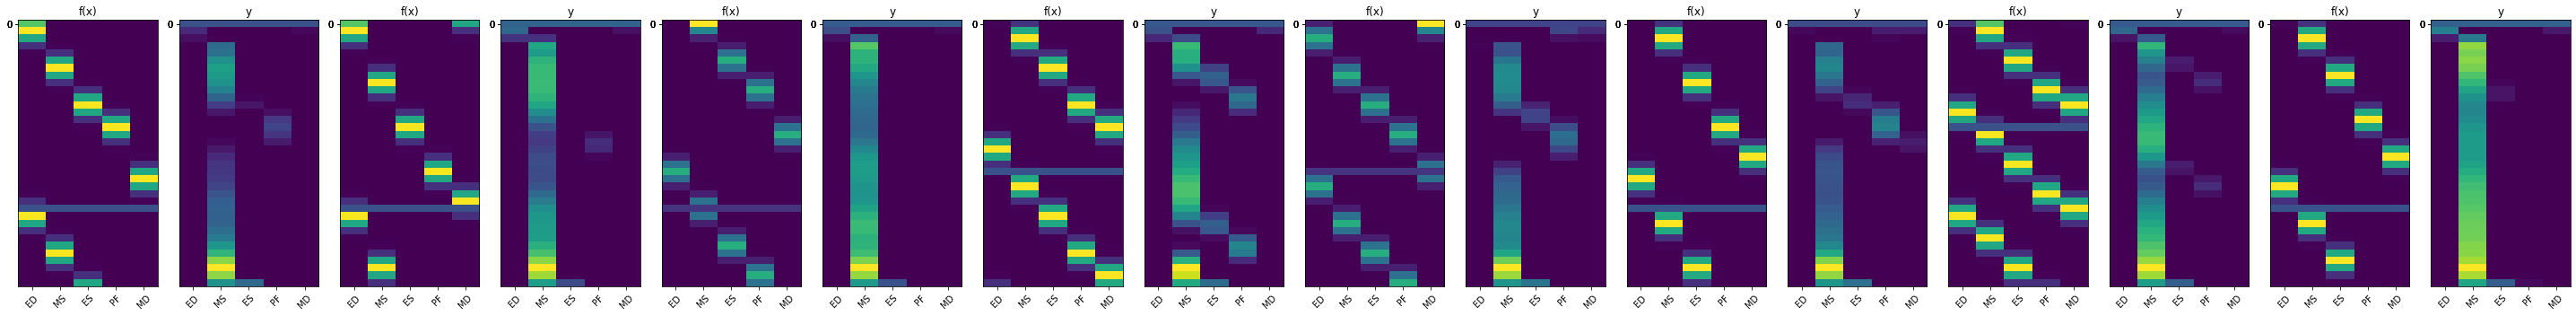

In [23]:
from src.visualization.Visualize import show_phases, show_phases_transpose
_ = show_phases(pred,outputs)

In [25]:
pred.shape

TensorShape([8, 2, 36, 5])

In [14]:
# calculate the meandiff score for one batch
from src.utils.Metrics import meandiff
score_fn = meandiff
score_fn(outputs, pred).numpy()

24.776663

In [14]:
temp = outputs[:,0,...]
print(temp.shape)
print(temp.T.shape)
plt.imshow(temp.T[0])

NameError: name 'outputs' is not defined

In [15]:
# calculate the meandiff score for all batches
# calculate the meandiff score for one batch
from src.utils.Metrics import meandiff
score_fn = meandiff
scores = []
for batch in validation_generator:
    x,y = batch
    p = model(x)
    scores.append(score_fn(y,p))
scores

ModuleNotFoundError: No module named 'src.utils.Metrics'

In [18]:
tf.reduce_mean(scores).numpy()

6.75

# Generator tests

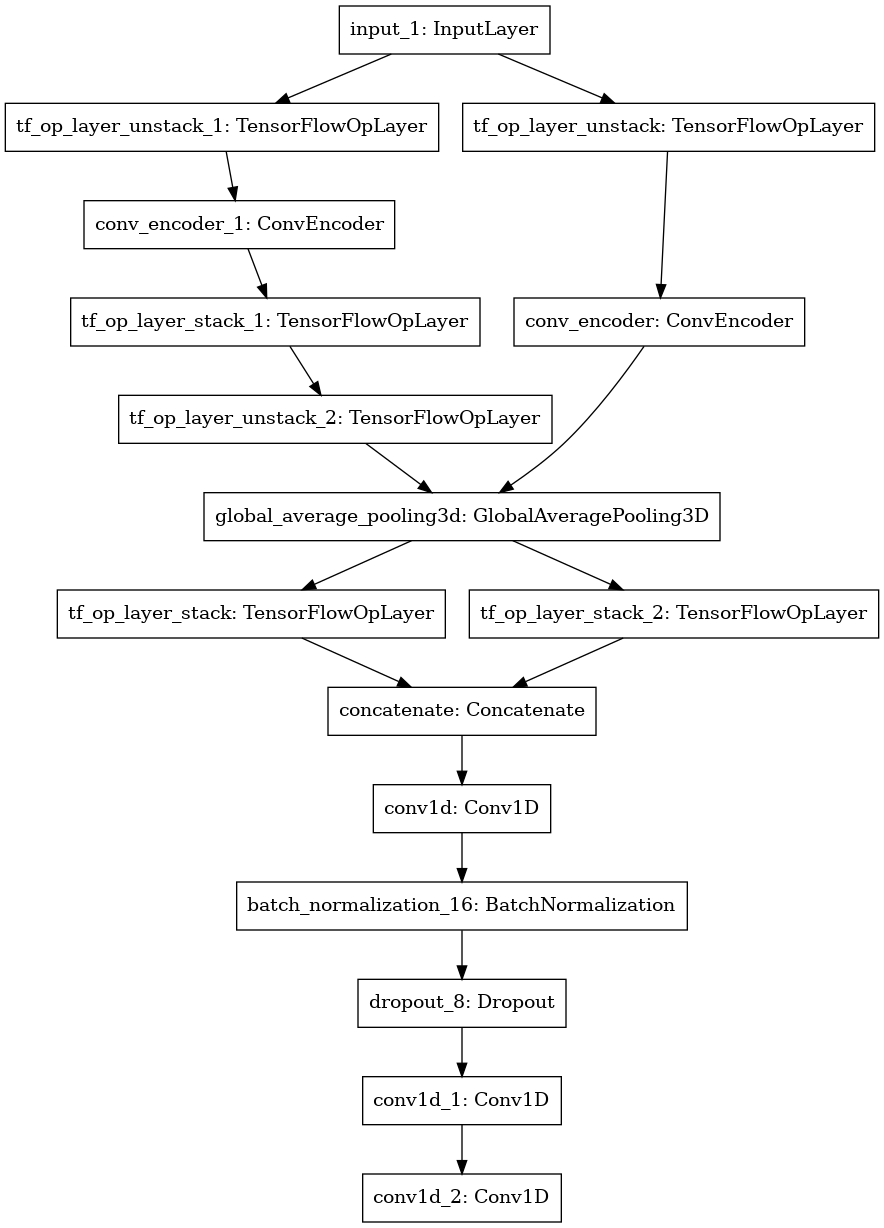

In [16]:
tf.keras.utils.plot_model(
    model, show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
)

In [19]:
score_fn = meandiff_
score_fn(outputs, pred).numpy()

1.75

In [ ]:
onehot = np.array([[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]])

In [ ]:
onehot.shape

In [ ]:
onehot_t = onehot.T
onehot_t.shape
onehot_t

In [ ]:
print(np.argmax(onehot, axis=1))
print(np.argmax(onehot_t, axis=0))

In [ ]:
# iterate over the phases j
# linspace from i to i+1 from indices
temp = onehot_t[:,0].astype(float)
i = 0
j = 3 + 1
temp[i:j] = np.linspace(i,j,j-i)
temp

In [ ]:
onehot_t = onehot_t.astype(float)
indices = np.argmax(onehot_t, axis=0)
for i in range(onehot_t.shape[1]) :
    start = indices[i]
    # make it a ring
    second = (i+1)%len(indices)
    end = indices[second]
    onehot_t[start:end,i] = np.linspace(1,0,int(end-start))
onehot_t
             
    

In [ ]:
plt.imshow(temp)

In [ ]:
plt.imshow(temp.T)

In [ ]:
%%timeit
temp.mean()

In [ ]:
%%timeit
np.mean(temp)

In [ ]:
np.linspace(-1,1,10)